In [81]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
import DCM
import pickle

In [83]:
df_raw = pd.read_excel('../ALP/alp481/ms481_weighted.xlsx')
df_raw = df_raw[df_raw['reward'] >=0]

# Questions about stock holding
for var in ['q3','q4','q6','q7','q12','q13','q15','q16']:
    df_raw[var] = df_raw[var].fillna(0)

# Some participants do not recall the exact amounts
# These participants are directed to a follow-up question: selecting from pre-defined ranges  
# rough_stock_holding = {1:0, 2: 500, 3: 2500, 4: 5000, 5: 10000, 6:30000, 7:100000, 8:200000}

rough_stock_holding = {
    1: (0, 500),
    2: (501, 2500),
    3: (2501, 5000),
    4: (5001, 10000),
    5: (10001, 30000),
    6: (30001, 100000),
    7: (100001, 200000),
    8: (200000, np.inf) 
}

'''
    1 Between $0 and $500 
    2 Between $501 and $2,500 
    3 Between $2,501 and $5,000 
    4 Between $5,001 and $10,000 
    5 Between $10,001 and $30,000 
    6 Between $30,001 and $100,000 
    7 Between $100,001 and $200,000 
    8 More than $200,000
'''

# Impute stock holding amounts by median of the collected exact amounts within the corresponding range
wealth_vars = {'q3': 'fund', 'q6':'indiv_stock', 'q12':'retire_fund', 'q15':'retire_stock'}
impute_holding = np.repeat(0, len(df_raw))

for var in ['q3','q6','q12','q15']:

    rough_var = 'q'+str(int(var[1:]) + 1)

    for hold_level in range(1,9):
        lower, upper = rough_stock_holding[hold_level]

        holding = df_raw[(df_raw[var] > lower) & (df_raw[var] <= upper)][var].median()
        
        impute_holding = impute_holding + holding * (df_raw[rough_var] == hold_level)

    df_raw[wealth_vars[var]] = df_raw[var].fillna(0) + impute_holding.fillna(0)

# Ratio of equity in individual stocks
df_raw['ratio_indiv_stock'] = df_raw['indiv_stock'] / (df_raw['indiv_stock'] + df_raw['fund'])

# Total financial wealth
df_raw['fin_wealth'] = df_raw['indiv_stock'] + df_raw['fund'] + df_raw['retire_stock'] + df_raw['retire_fund']


# Get the variables for the risky choices
# Each variable is formed as '{Task}_{Round}_{Node number}'
# For example, 'a2_2_2' implies Task a2, Round 2, Node 2
q_risk_vars = []
for var in df_raw.columns:
    if var.startswith('a') and len(var) > 1 and var[1].isdigit():
        q_risk_vars.append(var)

# Remove multiple choices
# Round 1: if choice = 1, must jump to Node 3; if choice = 2, must jump to Node 2
# Round 2, Node 2: if choice = 1, must jump to Node 5; if choice = 2, must jump to Node 4
# Round 2, Node 3: if choice = 1, must jump to Node 7; if choice = 2, must jump to Node 6
for q in q_risk_vars:

    q_round = int(q.split('_')[1])

    if q_round in [1,2]:
        q_loc = int(q.split('_')[2])
        if q_loc == 1:
            current_choice = df_raw[f"{q.split('_')[0]}_{q_round}_{q_loc}"]
            df_raw.loc[current_choice == 1, f"{q.split('_')[0]}_{q_round+1}_2"] == np.nan
            df_raw.loc[current_choice == 2, f"{q.split('_')[0]}_{q_round+1}_3"] == np.nan
        if q_loc == 2:
                current_choice = df_raw[f"{q.split('_')[0]}_{q_round}_{q_loc}"]
                df_raw.loc[current_choice == 1, f"{q.split('_')[0]}_{q_round+1}_4"] == np.nan
                df_raw.loc[current_choice == 2, f"{q.split('_')[0]}_{q_round+1}_5"] == np.nan
        if q_loc == 3:
                current_choice = df_raw[f"{q.split('_')[0]}_{q_round}_{q_loc}"]
                df_raw.loc[current_choice == 1, f"{q.split('_')[0]}_{q_round+1}_6"] == np.nan
                df_raw.loc[current_choice == 2, f"{q.split('_')[0]}_{q_round+1}_7"] == np.nan


# Calculate the choices for each specific question
prefixes = list(set(col.rsplit('_', 1)[0] for col in q_risk_vars))

for prefix in prefixes:
    matching_cols = [col for col in q_risk_vars if col.startswith(prefix)]
    df_raw[prefix] = df_raw[matching_cols].bfill(axis=1).iloc[:, 0]

# Each row is an indidvidual-choice dyad
df_risk_choice = df_raw[['prim_key']+prefixes].melt(id_vars='prim_key', var_name='q_risk', value_name='choice')

# Only keep the participants who complete all 6 Probabilty Weighting (PW) tasks 
pw_tasks = ['a7', 'a8', 'a9', 'a10', 'a11', 'a12']
pw_criteria = df_risk_choice['q_risk'].str.startswith(tuple(pw_tasks)) & \
                df_risk_choice['q_risk'].str.split('_').str[1].isin(['1','2','3'])

df_check = df_risk_choice[pw_criteria].groupby('prim_key').count()['choice']

df_risk_choice = df_risk_choice[df_risk_choice['prim_key'].isin(df_check[df_check == 18].index)]

print('Number of participants who complete all PW tasks:',len(df_risk_choice['prim_key'].unique()))

Number of participants who complete all PW tasks: 2671


In [169]:
df_risk_task = df_risk_choice[df_risk_choice['q_risk'].str.split('_').str[1].isin(['1','2','3'])]
df_risk_task['q_task'] = df_risk_task['q_risk'].str.split('_').str[0]
df_risk_task['q_round'] = df_risk_task['q_risk'].str.split('_').str[1]

# Each row is an individual-task dyad
df_risk_task = df_risk_task.pivot_table(
    index = ['prim_key','q_task'],
    columns = 'q_round',
    values = 'choice'
).reset_index()

df_risk_task.columns = ['prim_key','q_task','round1_choice','round2_choice','round3_choice']

# Import the Bi-Section Paths for all tasks
# choice = 1: Option A; choice = 2: Option B
df_all_tasks = pd.read_csv('../ALP/alp481/all_tasks.csv').iloc[:,1:]
df_all_tasks.replace({'A':1, 'B':2}, inplace=True)

df_risk_task = pd.merge(left = df_risk_task, right = df_all_tasks, on = ['q_task','round1_choice','round2_choice','round3_choice'])
df_risk_task['premium'] = df_risk_task['premium'].str.strip('%').astype(float) / 100

# Probability Weighting (PW) task: a7, a9, a11 (underweight), a8, a10, a12 (overweight)
# Risk Aversion (RA) task: a2, a3, a4, a5
df_inverseS_1 = df_risk_task[df_risk_task['q_task'].isin(['a7','a9','a11'])].groupby('prim_key')['premium'].sum()
df_inverseS_2 = df_risk_task[df_risk_task['q_task'].isin(['a8','a10','a12'])].groupby('prim_key')['premium'].sum()
df_inverseS_3 = df_risk_task[df_risk_task['q_task'].isin(['a2','a3','a4','a5'])].groupby('prim_key')['premium'].mean()

df_inverseS_1 = df_inverseS_1.reset_index().rename(columns={'premium':'underweight'})
df_inverseS_2 = df_inverseS_2.reset_index().rename(columns={'premium':'overweight'})
df_inverseS_3 = df_inverseS_3.reset_index().rename(columns={'premium':'riskaversion'})

df_inverseS = pd.merge(df_inverseS_1, df_inverseS_2, on='prim_key', how='inner')
df_inverseS = pd.merge(df_inverseS, df_inverseS_3, on='prim_key', how='inner')

df_inverseS['inverse_S'] = df_inverseS['underweight'] - df_inverseS['overweight']

# Check whether the preimums match Table 1 in the original paper
df_check_premium = pd.merge(left=df_risk_task,right=df_raw[['prim_key','weight']],on='prim_key')
df_check_premium.groupby('q_task').apply(lambda x: sum(x['premium'] * x['weight']) / sum(x['weight']))

C:\Users\zarkwang\AppData\Local\Temp\ipykernel_17684\3327634095.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_risk_task['q_task'] = df_risk_task['q_risk'].str.split('_').str[0]
C:\Users\zarkwang\AppData\Local\Temp\ipykernel_17684\3327634095.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_risk_task['q_round'] = df_risk_task['q_risk'].str.split('_').str[1]
C:\Users\zarkwang\AppData\Local\Temp\ipykernel_17684\3327634095.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and w

q_task
a10   -0.022534
a11    0.281941
a12   -0.070295
a2     0.184185
a3     0.142526
a4     0.156146
a5     0.166093
a7     0.150403
a8     0.046344
a9     0.230626
dtype: float64

In [170]:
covariates = ['gender', #1 Male 2 Female
 'calcage', #age
 'currentlivingsituation', # 1 Married, 2 Separated, 3 Divorced, 4 Widowed, 5 Never married
 'ethnicity', #1 White, 2 Black, 3 American Indian or Alaskan Native, 4 Asian or Pacific Islander, 5 Other
 'hispaniclatino', #1 Yes, 2 No
 'householdmembers',
 'currentjobstatuss1', #1 Employed, NaN Other
 'highesteducation', #1 Less than 1st grade, 2 1-4th grade, 3 5-6th grade, 4 7-8th grade, 5 9th grade, 6 10th grade, 7 11th grade, 8 12th grade NO DIPLOMA, 9 HIGH SCHOOL GRADUATE, 10 Some college but no degree, 11 Associate degree in college Occupational/vocational program, 12 Associate degree in college Academic program, 13 Bachelor's degree, 14 Master's degree, 15 Professional School Degree, 16 Doctorate degree
 'familyincome', #1 Less than $5,000 2 $5,000 to $7,499 3 $7,500 to $9,999 4 $10,000 to $12,499 5 $12,500 to $14,999 6 $15,000 to $19,999 7 $20,000 to $24,999 8 $25,000 to $29,999 9 $30,000 to $34,999 10 $35,000 to $39,999 11 $40,000 to $49,999 12 $50,000 to $59,999 13 $60,000 to $74,999 14 $75,000 or more
 'familyincome_part2', #1 $75,000-$99,999 2 $100,000-$124,999 3 $125,000-$199,999 4 $200,000 or more
 'q19', #buy a lottery ticket, play at a casino, play a slot machine, or bet online in the last 3 months. 1 Yes, 2 No
 'q20', #Financial Literacy (interest): correct = 1
 'q21', #Financial Literacy (inflation): correct = 3
 'q22', #Financial Literacy (diversification): correct = 2
 'q23', #Numeracy (1): correct = 3
 'q24', #Numeracy (2): correct = 2
 'q25', #Numeracy (3): correct = 2
 'q26', #Trust 0-5: 0 Most people can be trusted, 5 you can’t be too careful in dealing with people
 'q27', #How long do you think you will live? Puri and Robinson (2007)
 ]

# Merge stock holding data and risky choice data
df_reg = pd.merge(left = df_raw[['prim_key','weight','ratio_indiv_stock','fin_wealth'] + covariates], 
                  right= df_inverseS,
                  on='prim_key')

df_reg = df_reg.rename(columns = {'calcage': 'age', 'q26':'trust'})

# optimism: difference between self-reported and estimated life expectancy
df_mortality = pd.read_csv('../ALP/alp481/mortality_table.csv')

def life_expectancy(age,gender): 

    round_floor = np.floor(age / 5) * 5
    round_ceil = np.ceil(age / 5) * 5

    floor_diff = np.abs(age - round_floor)
    ceil_diff = np.abs(age - round_ceil)

    nearest = np.where(floor_diff <= ceil_diff, round_floor, round_ceil)

    gender_encode = {1:'male',2:'female'}
    gender_label = gender_encode.get(gender)

    life_exp = df_mortality[df_mortality['age'] == nearest][gender_label] + nearest

    return life_exp.values[0]

df_reg['life_exp'] = df_reg.apply(lambda row: life_expectancy(row['age'], row['gender']), axis=1)
df_reg['optimism'] = df_reg['q27'] - df_reg['life_exp']

# gender, married, white, hispanic, employed, gambling, age
df_reg['male'] = df_reg['gender'] == 1
df_reg['married'] = df_reg['currentlivingsituation'] == 1
df_reg['white'] = df_reg['ethnicity'] == 1
df_reg['hispanic'] = df_reg['hispaniclatino'] == 1
df_reg['employed'] = df_reg['currentjobstatuss1'] == 1
df_reg['gambling'] = df_reg['q19'] == 1

df_reg['age2'] = df_reg['age']**2
df_reg['age_group'] = np.floor(df_reg['age'] / 10) * 10

# education
df_reg['no_college_degree'] = df_reg['highesteducation'] <= 10
df_reg['bachelor_degree'] = df_reg['highesteducation'].between(11,13)
df_reg['master_degree'] = df_reg['highesteducation'].between(14,16)

# financial literacy & numeracy
df_reg['fin_literacy'] = (df_reg['q20'] == 1).astype(int) + (df_reg['q21'] == 3).astype(int) + (df_reg['q22'] == 2).astype(int)
df_reg['numeracy'] = (df_reg['q23'] == 3).astype(int) + (df_reg['q24'] == 2).astype(int) + (df_reg['q25'] == 2).astype(int)

# family income & financial wealth
df_reg['familyincome_rank'] = (df_reg['familyincome_part2'] - 1).fillna(0) + df_reg['familyincome'].fillna(0)

income_lower = {1: 0, 2: 5000, 3: 7500, 4: 10000, 5: 12500, 6: 15000,
                7: 20000, 8: 25000, 9: 30000, 10: 35000, 11: 40000, 12: 50000, 13: 60000,
                14: 75000, 15: 100000, 16: 125000, 17: 200000}

df_reg['familyincome_value'] = df_reg.apply(lambda row: income_lower.get(row['familyincome_rank']),axis=1) / 1e3
df_reg['fin_wealth'] = df_reg['fin_wealth'] / 1e3

df_reg = df_reg.astype({col: 'int' for col in df_reg.columns if df_reg[col].dtype == 'bool'})

# Control variables
exog_cols = [
            'inverse_S','riskaversion',
             'age','age2',
             'age_group','male',
             'married','white','hispanic','employed','householdmembers',
             'no_college_degree','bachelor_degree',
             'familyincome_value',
             'fin_wealth',
             'fin_literacy','numeracy','trust',
             'optimism',
             'gambling'
             ]

# Some participants report "don't know" for q27 (optimism) and family income, which creates NAs.
# Impute missing values with the group median 
df_reg['missing_value'] = df_reg.isna().any(axis=1).astype(int)

demographic_group = ['age_group','male','no_college_degree','bachelor_degree','master_degree']

impute_optimism = df_reg.groupby(demographic_group)['optimism'].median().reset_index()
impute_familyincome = df_reg.groupby(demographic_group)['familyincome_value'].median().reset_index()

df_reg = pd.merge(df_reg, impute_optimism, on=demographic_group, how='left', suffixes=('', '_imputed'))
df_reg = pd.merge(df_reg, impute_familyincome, on=demographic_group, how='left', suffixes=('', '_imputed'))
df_reg['optimism'] = df_reg['optimism'].fillna(df_reg['optimism_imputed'])
df_reg['familyincome_value'] = df_reg['familyincome_value'].fillna(df_reg['familyincome_value_imputed'])

exog_cols.remove('age_group')
exog_cols = exog_cols + ['missing_value']

# Only keep the individuals who hold equities 
df_reg = df_reg[~df_reg['ratio_indiv_stock'].isna()]
df_reg = df_reg[['prim_key','weight','ratio_indiv_stock']+exog_cols]

valid_prim_keys = df_reg['prim_key']
print("Number of participants in the regression sample:", len(valid_prim_keys))

# Standardize all non-binary variables (except age)
# for var in ['inverse_S','riskaversion','householdmembers',
#              'familyincome_value','fin_wealth',
#              'fin_literacy','numeracy','trust','optimism']:
#     df_reg[var] = (df_reg[var] - df_reg[var].mean()) / df_reg[var].std()

Number of participants in the regression sample: 741


In [5]:
summary_controls = df_reg[exog_cols].describe().T[['mean','std','min','max']].iloc[2:,:].round(3).astype(str)
DCM.make_table(summary_controls,'tables/probWeigh_controls.tex')
summary_controls

,mean,std,min,max
age,60.463,13.215,20.0,94.0
age2,3830.169,1534.306,400.0,8836.0
male,0.526,0.5,0.0,1.0
married,0.668,0.471,0.0,1.0
white,0.901,0.298,0.0,1.0
hispanic,0.042,0.2,0.0,1.0
employed,0.563,0.496,0.0,1.0
householdmembers,0.614,1.063,0.0,7.0
no_college_degree,0.212,0.409,0.0,1.0
bachelor_degree,0.43,0.495,0.0,1.0


In [86]:
endog = df_reg['ratio_indiv_stock']
exog = sm.add_constant(df_reg[exog_cols])

reg_result = sm.WLS(endog, exog, weights=df_reg['weight']).fit()
reg_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:      ratio_indiv_stock   R-squared:                       0.105
Model:                            WLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     4.211
Date:                Sat, 01 Feb 2025   Prob (F-statistic):           3.06e-09
Time:                        02:40:44   Log-Likelihood:                -465.62
No. Observations:                 741   AIC:                             973.2
Df Residuals:                     720   BIC:                             1070.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2074      0.196      1.056      0.291      -0.178       0.593
inverse_S              0.0469      0.019      2.480      0.013       0.010       0.084
riskaversion          -0.0159      0.064     -0.251      0.802      -0.141       0.109
age                    0.0045      0.006      0.737      0.461      -0.008       0.017
age2               -4.209e-05   5.99e-05     -0.702      0.483      -0.000    7.56e-05
male                   0.0706      0.031      2.252      0.025       0.009       0.132
married               -0.0437      0.036     -1.200      0.230      -0.115       0.028
white                 -0.1186      0.050     -2.395      0.017      -0.216      -0.021
hispanic               0.0871      0.064      1.363      0.173      -0.038       0.213
employed              -0.0306      0.045     -0.680      0.497      -0.119       0.058
householdmembers      -0.0139      0.014     -1.022      0.307      -0.041       0.013
no_college_degree      0.1279      0.042      3.021      0.003       0.045       0.211
bachelor_degree        0.0943      0.039      2.400      0.017       0.017       0.171
familyincome_value     0.0009      0.000      2.499      0.013       0.000       0.002
fin_wealth         -1.052e-05   2.91e-06     -3.617      0.000   -1.62e-05   -4.81e-06
fin_literacy          -0.0035      0.024     -0.144      0.885      -0.051       0.044
numeracy               0.0226      0.028      0.801      0.423      -0.033       0.078
trust                  0.0205      0.011      1.828      0.068      -0.002       0.042
optimism              -0.0051      0.001     -4.282      0.000      -0.007      -0.003
gambling               0.0167      0.030      0.552      0.581      -0.043       0.076
missing_value          0.0084      0.045      0.186      0.853      -0.081       0.098
==============================================================================
Omnibus:                        1.923   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.382   Jarque-Bera (JB):                1.965
Skew:                          -0.122   Prob(JB):                        0.374
Kurtosis:                       2.939   Cond. No.                     7.55e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.55e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

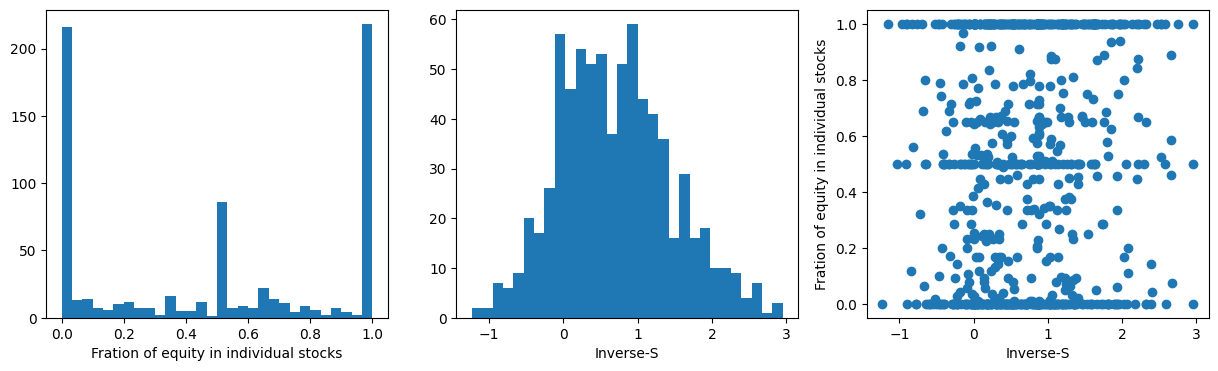

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.hist(df_reg['ratio_indiv_stock'],bins=30)
ax1.set_xlabel('Fration of equity in individual stocks')

ax2.hist(df_reg['inverse_S'],bins=30)
ax2.set_xlabel('Inverse-S')

ax3.scatter(df_reg['inverse_S'],df_reg['ratio_indiv_stock'])
ax3.set_xlabel('Inverse-S')
ax3.set_ylabel('Fration of equity in individual stocks')

plt.show()

In [117]:
# Tobit model
tobit = DCM.tobit_WLS(y = endog,X = exog, weights = df_reg['weight'])
tobit.fit(robust=True)
tobit.result_summary()

LR: 35.4727, Degree of freedom: 20, F-test pvalue: 0.0177
Pseudo R²: 0.0300


,variable,coef,se,t,p
0,const,0.006463,0.243636,0.026525,9.788457e-01
1,inverse_S,0.078368,0.025526,3.070116,2.220312e-03
2,riskaversion,-0.001537,0.082199,-0.018693,9.850911e-01
3,age,0.002098,0.007422,0.282690,7.774962e-01
4,age2,-0.000048,0.000073,-0.657401,5.111334e-01
5,male,0.056846,0.040612,1.399723,1.620276e-01
6,married,-0.027269,0.049510,-0.550783,5.819538e-01
7,white,-0.025738,0.066178,-0.388927,6.974456e-01
8,hispanic,0.028561,0.090979,0.313927,7.536679e-01
9,employed,-0.019310,0.054871,-0.351926,7.249967e-01


In [172]:
# RA tasks
# Option A: win $[a_amount_1] with 33% chance, or else $[a_amount_2] with 67% chance.
# Option B: win $X with 33% chance 
ra_prob_a = [np.array([0.33,0.67])]*4
ra_prob_b = [0.33]*4
ra_amount_a = [np.array(a) for a in [[12,3],[18,3],[24,3],[30,3]]]

# PW tasks
# Option A: win $42 with [a_prob] chance, or else $6 with [1-a_prob] chance.
# Option B: win $X for sure
pw_prob_a = [np.array([p,1-p]) for p in [0.5,0.25,0.75,0.12,0.88,0.05]]
pw_prob_b = [1]*6
pw_amount_a = [np.array([42,6])]*6

task_list = ['a2','a3','a4','a5','a7', 'a8', 'a9', 'a10', 'a11', 'a12']

task_setup = {'q_task': task_list,
              'prob_a': ra_prob_a + pw_prob_a,
              'prob_b': ra_prob_b + pw_prob_b,
              'amount_a': ra_amount_a + pw_amount_a}

# Create variables for these attributes
df_risk = pd.merge(left = df_risk_task,
                    right = pd.DataFrame(task_setup),
                    on = 'q_task')

for var in ['prob_a','prob_b','amount_a']:
    df_risk[f'round1_{var}'] = df_risk[var]
    df_risk[f'round2_{var}'] = df_risk[var]
    df_risk[f'round3_{var}'] = df_risk[var]

# Each row represents an individual
df_risk = df_risk.pivot_table(index = 'prim_key',
                    columns = 'q_task',
                    values = [col for col in df_risk.columns if 'round' in col],
                    aggfunc='first')

df_risk.columns = [f'{task}_{col}' for col, task in df_risk.columns]
df_risk = df_risk[sorted(df_risk.columns)][[col for col in df_risk.columns if 'round' in col]].reset_index()

# Relabel: 1 = choosing option A, 0 = choosing option B
choice_cols = [col for col in df_risk.columns if 'choice' in col]
df_risk[choice_cols] = 2 - df_risk[choice_cols]

df_equity = pd.merge(left = df_reg[['prim_key','weight']],right = df_risk,on='prim_key').dropna()
print('Number of participants for model estimation:',len(df_equity))

# Specify x1, x2, p1, p2
p_a = [col for col in df_equity.columns if 'prob_a' in col]
p_b = [col for col in df_equity.columns if 'prob_b' in col]
x_a = [col for col in df_equity.columns if 'amount_a' in col]
x_b = [col for col in df_equity.columns if 'x' in col and 'round4' not in col]

# df_risk[x_b].astype(float)

Number of participants for model estimation: 737


In [8]:
# Fit model for each task
param_key_list = ['riskCoef','probW','temp']
metric_list = ['accuracy','RMSE','cross-entropy']
result_const_fit = {key:[] for key in (['task'] + param_key_list + metric_list)}

for t in task_list:
    p_a_t = [col for col in p_a if t in col]
    p_b_t = [col for col in p_b if t in col]
    x_a_t = [col for col in x_a if t in col]
    x_b_t = [col for col in x_b if t in col]
    choice_t = [col for col in choice_cols if t in col]

    bounds = [(0,1),(0,1),(0,None)]

    model_t = DCM.mixedDiscrete(data=df_equity,
                choice = choice_t,
                x1 = x_a_t,
                x2 = x_b_t,
                p1 = p_a_t,
                p2 = p_b_t)

    model_t.set_init_param(param_keys=param_key_list,
                     param_init=[0.5,0.5,1],
                     weight = df_equity['weight'].values)

    model_t.fit_param(bounds=bounds,show=False)
    pred_t = model_t.predict()
    
    result_const_fit['task'] += [t]

    for i in range(len(param_key_list)):
        result_const_fit[param_key_list[i]] += [model_t.result.x[i]]
    
    for m in metric_list:
        result_const_fit[m] += [pred_t[m]]

pd.DataFrame(result_const_fit)


c:\Users\phd19zw1\OneDrive - University of Warwick\preference_reanalysis\staircase\utils.py:65: RuntimeWarning: divide by zero encountered in divide
  prob = 1/(1+ np.exp(-u_diff / params['temp']))
c:\Users\phd19zw1\OneDrive - University of Warwick\preference_reanalysis\staircase\DCM.py:146: RuntimeWarning: divide by zero encountered in log
  logLogit = y*np.log(p) + (1-y)*np.log(1-p)
c:\Users\phd19zw1\OneDrive - University of Warwick\preference_reanalysis\staircase\DCM.py:146: RuntimeWarning: invalid value encountered in multiply
  logLogit = y*np.log(p) + (1-y)*np.log(1-p)
c:\Users\phd19zw1\OneDrive - University of Warwick\preference_reanalysis\staircase\utils.py:65: RuntimeWarning: overflow encountered in exp
  prob = 1/(1+ np.exp(-u_diff / params['temp']))
c:\Users\phd19zw1\OneDrive - University of Warwick\preference_reanalysis\staircase\utils.py:65: RuntimeWarning: invalid value encountered in divide
  prob = 1/(1+ np.exp(-u_diff / params['temp']))
c:\Users\phd19zw1\OneDrive - Uni

,task,riskCoef,probW,temp,accuracy,RMSE,cross-entropy
0,a2,0.000000,0.610102,1.002570,0.637111,0.231201,0.655062
1,a3,0.017641,0.636136,1.595570,0.619763,0.236569,0.666080
2,a4,0.000000,0.661625,1.232600,0.615391,0.236685,0.666275
3,a5,0.000000,0.000000,2.566341,0.535775,0.248720,0.690585
4,a7,0.143503,0.874203,0.253391,0.615275,0.237877,0.668897
5,a8,0.000000,0.272524,0.792045,0.554767,0.247001,0.687136
6,a9,0.008770,0.942184,0.019872,0.635976,0.231016,0.654707
7,a10,0.000000,0.480375,1.272231,0.514275,0.249796,0.692740
8,a11,0.110296,0.652746,0.067430,0.732601,0.187549,0.561299
9,a12,0.815646,0.000000,27.548481,0.571684,0.245181,0.683485


In [173]:
bounds = [(0,1),(0,1),(0,None)]

model = DCM.mixedDiscrete(data=df_equity,
                choice = choice_cols,
                x1 = x_a,
                x2 = x_b,
                p1 = p_a,
                p2 = p_b)

model.set_init_param(param_keys=['riskCoef','probW','temp'],
                     param_init=[0.5,0.5,1],
                     weight = df_equity['weight'].values)

model.fit_param(bounds=bounds)
const_params = model.result.x
pred_with_const_params = model.predict()
pred_with_const_params['approx_log_like'] = model.result.fun / 1000

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 14842809.491503468
        x: [ 3.320e-01  1.678e-01  1.395e+00]
      nit: 11
      jac: [ 1.118e+00 -5.588e-01 -1.118e+00]
     nfev: 48
     njev: 12
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


In [29]:
DCM.get_best_result(model,bounds,n_class=2,n_init_point=8,name_prefix='models_prob_weigh/pw',name_suffix='3param')

np.float64(13987.57082118724)

In [30]:
DCM.get_best_result(model,bounds,n_class=3,n_init_point=8,name_prefix='models_prob_weigh/pw',name_suffix='3param')

np.float64(13920.239206137792)

In [31]:
DCM.get_best_result(model,bounds,n_class=4,n_init_point=8,name_prefix='models_prob_weigh/pw',name_suffix='3param')

np.float64(14154.460897755178)

In [ ]:
DCM.get_best_result(model,bounds,n_class=5,n_init_point=8,name_prefix='models_prob_weigh/pw',name_suffix='3param')

np.float64(13953.139794162511)

In [10]:
DCM.get_best_result(model,bounds,n_class=6,n_init_point=8,name_prefix='models_prob_weigh/pw',name_suffix='3param')

np.float64(14006.573966800188)

In [12]:
bounds = [(0,1),(0,1)]

model = DCM.mixedDiscrete(data=df_equity,
                choice = choice_cols,
                x1 = x_a,
                x2 = x_b,
                p1 = p_a,
                p2 = p_b,
                fixed_args ={'temp': 1.38})

model.set_init_param(param_keys=['riskCoef','probW'],
                     param_init=[0.5,0.5],
                     weight = df_equity['weight'].values)

model.fit_param(bounds=bounds)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 14842830.891673028
        x: [ 3.296e-01  1.683e-01]
      nit: 7
      jac: [-7.451e-01  1.863e-01]
     nfev: 30
     njev: 10
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


In [13]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 1.8],
                     n_class=2, n_init_point = 8, name_prefix = 'models_prob_weigh/pw')

Searching optimal value for temp
Step 1: 0.7333333333333333
Evaluation metrics: 14808.355783084697, 15049.214815057952
Step 2: 0.9111111111111111
Evaluation metrics: 15158.279034516372, 14803.41721795743
Step 3: 1.0296296296296297
Evaluation metrics: 15074.227312299035, 15052.164405752352
Step 4: 0.9506172839506173
Evaluation metrics: 14794.885448396244, 15050.595084395962
Step 5: 1.0032921810699587
Evaluation metrics: 14807.551213168656, 14787.441334664805
Step 6: 0.9681755829903977
Evaluation metrics: 14792.028962676019, 15051.925057473012
Step 7: 0.9915866483767717
Evaluation metrics: 15055.958185759604, 14788.823417284984
Step 8: 0.9759792714525224
Evaluation metrics: 14790.892337715482, 15052.850178478375
Step 9: 0.9863841894020219
Evaluation metrics: 15054.74557858968, 14789.478180919547
Step 10: 0.993320801368355
Evaluation metrics: 14790.402833185502, 14788.617849985163


({'temp': 0.993320801368355}, np.float64(14788.606228395387))

In [14]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 1.8],
                     n_class=3, n_init_point = 8, name_prefix = 'models_prob_weigh/pw')

Searching optimal value for temp
Step 1: 0.7333333333333333
Evaluation metrics: 14770.014067266562, 14991.217090553646
Step 2: 0.9111111111111111
Evaluation metrics: 15195.18552436423, 14745.279707054713
Step 3: 1.0296296296296297
Evaluation metrics: 14763.997230369889, 14726.635838999951
Step 4: 1.1086419753086418
Evaluation metrics: 14737.292445183088, 14720.343611805418
Step 5: 1.0559670781893002
Evaluation metrics: 14724.160096947648, 14933.770447888737
Step 6: 1.0910836762688614
Evaluation metrics: 14727.56195139321, 14721.463852024735
Step 7: 1.0676726108824872
Evaluation metrics: 14723.190447437053, 14986.210214330049
Step 8: 1.052065233958238
Evaluation metrics: 14724.50202804771, 14926.813122637268
Step 9: 1.0624701519077377
Evaluation metrics: 14725.453594061335, 14723.615444980116
Step 10: 1.0694067638740705
Evaluation metrics: 14724.197378671506, 14723.055762840208


({'temp': 1.0694067638740705}, np.float64(14723.055586962559))

In [15]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 1.8],
                     n_class=4, n_init_point = 8, name_prefix = 'models_prob_weigh/pw')

Searching optimal value for temp
Step 1: 1.2666666666666666
Evaluation metrics: 14862.33369345615, 14804.256309246903
Step 2: 1.088888888888889
Evaluation metrics: 14513.347016649099, 14846.872477859954
Step 3: 1.2074074074074075
Evaluation metrics: 14891.610906276144, 14790.493620497497
Step 4: 1.128395061728395
Evaluation metrics: 14773.166847827059, 14808.936139286052
Step 5: 1.0757201646090535
Evaluation metrics: 14762.739550629636, 14784.569342814037
Step 6: 1.0406035665294926
Evaluation metrics: 14756.439390816813, 14769.563563927364
Step 7: 1.0171925011431184
Evaluation metrics: 14752.672764717789, 14760.642354525768
Step 8: 1.0015851242188691
Evaluation metrics: 14750.318895130406, 14755.137181372604
Step 9: 1.0119900421683687
Evaluation metrics: 14885.359475329431, 14751.85157088747
Step 10: 1.0050534302020357
Evaluation metrics: 14506.958001572146, 14752.915430629106


({'temp': 1.0050534302020357}, np.float64(14750.820884723367))

In [16]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 1.8],
                     n_class=5, n_init_point = 8, name_prefix = 'models_prob_weigh/pw')

Searching optimal value for temp
Step 1: 1.2666666666666666
Evaluation metrics: 15023.309736346047, 14685.660187761749
Step 2: 1.088888888888889
Evaluation metrics: 14892.158042827778, 15107.130458602882
Step 3: 1.2074074074074075
Evaluation metrics: 14914.415409769426, 14848.940424343982
Step 4: 1.128395061728395
Evaluation metrics: 15040.04295739982, 15065.925854759524
Step 5: 1.0757201646090535
Evaluation metrics: 14644.539558779918, 15052.006245079083
Step 6: 1.1108367626886146
Evaluation metrics: 14902.916274136289, 14651.69244374773
Step 7: 1.0874256973022405
Evaluation metrics: 14892.524727710977, 15036.780106095088
Step 8: 1.1030330742264898
Evaluation metrics: 14896.283697519557, 14650.083952109126
Step 9: 1.0926281562769904
Evaluation metrics: 14891.206636114825, 15036.515099688484
Step 10: 1.0995647682433232
Evaluation metrics: 14892.962110185816, 14889.381878948137


({'temp': 1.0995647682433232}, np.float64(15032.48811709068))

In [17]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 1.8],
                     n_class=6, n_init_point = 8, name_prefix = 'models_prob_weigh/pw')

Searching optimal value for temp
Step 1: 1.2666666666666666
Evaluation metrics: 15227.148115553255, 14952.266534458042
Step 2: 1.088888888888889
Evaluation metrics: 14907.218269307654, 15119.571758334463
Step 3: 1.2074074074074075
Evaluation metrics: 14985.951797516482, 14939.343371296378
Step 4: 1.128395061728395
Evaluation metrics: 14923.224584063659, 15085.231160490925
Step 5: 1.1810699588477367
Evaluation metrics: 15140.535845770386, 15121.117913976552
Step 6: 1.2161865569272976
Evaluation metrics: 15090.644340836061, 14941.320104859504
Step 7: 1.2395976223136718
Evaluation metrics: 15114.978212076257, 14946.036597612041
Step 8: 1.2552049992379213
Evaluation metrics: 15050.746743342399, 14949.928905451434
Step 9: 1.2448000812884215
Evaluation metrics: 14947.385789676286, 15228.322993729409
Step 10: 1.2517366932547547
Evaluation metrics: 14935.56044903033, 14934.191937876418


({'temp': 1.2517366932547547}, np.float64(14947.80095920594))

In [8]:
df_filtered = df_raw[['prim_key']+q_risk_vars].melt(id_vars = 'prim_key',
                                      var_name = 'q_risk',
                                      value_name = 'choice',
                                      value_vars = q_risk_vars).dropna()

df_filtered = df_filtered[df_filtered['q_risk'].str.split('_').str[1].eq('3')]
df_filtered = df_filtered[df_filtered['prim_key'].isin(valid_prim_keys)]

df_filtered['task'] = df_filtered['q_risk'].str.split('_').str[0]
df_filtered['round3'] = df_filtered['q_risk'].str.split('_').str[2].astype(int)
df_filtered['rank'] = (df_filtered['round3'] - 4)*2 + (3 - df_filtered['choice'])
tab_count_all = df_filtered[['prim_key','task','rank']].dropna().groupby(['task','rank']).count().reset_index()

for i in range(len(task_list)):
    tab_count = tab_count_all[tab_count_all['task'] == task_list[i]].sort_values('rank')
    tab_count = tab_count[['rank','prim_key']].set_index('rank')['prim_key']
    tab_count.index = tab_count.index.astype(int).astype(str)

    result_prop_test = DCM.prop_test(tab_count,hide=True)
    p_fisher = DCM.prop_test_pvalue(result_prop_test,method='fisher')
    p_barnard = DCM.prop_test_pvalue(result_prop_test,method='barnard')
    
    print(f'task:{task_list[i]}, Fisher p-value: {p_fisher}, Barnard p-value: {p_barnard}')

task:a2, Fisher p-value: 1.3779862742313282e-27, Barnard p-value: 3.3887362144703075e-23
task:a3, Fisher p-value: 6.153031092758909e-26, Barnard p-value: 3.333495601456695e-23
task:a4, Fisher p-value: 1.1248669398773394e-21, Barnard p-value: 1.0121598549551455e-18
task:a5, Fisher p-value: 6.024142679574086e-23, Barnard p-value: 2.0913419420607194e-22
task:a7, Fisher p-value: 3.3769125805714923e-16, Barnard p-value: 1.6316831209503038e-14
task:a8, Fisher p-value: 2.347640357107383e-36, Barnard p-value: 1.4004231511746772e-35
task:a9, Fisher p-value: 3.082748063589614e-18, Barnard p-value: 1.0468767594295671e-08
task:a10, Fisher p-value: 1.2509563626555807e-22, Barnard p-value: 3.7574099758599558e-22
task:a11, Fisher p-value: 9.702562228849847e-07, Barnard p-value: 0.002542251560294641
task:a12, Fisher p-value: 1.0343681241541295e-34, Barnard p-value: 6.708503972978894e-35


In [18]:
model = DCM.mixedNormal(data=df_equity,
                choice = choice_cols,
                x1 = x_a,
                x2 = x_b,
                p1 = p_a,
                p2 = p_b
                )

model.set_init_mixed(meta_param = {'mean':[0.1,0.1],'variance':[[1,0.1],[0.1,1]]}, 
                     param_keys = ['riskCoef','probW'],
                     dist_type = ['johnson_sb','johnson_sb'],
                     constant_param = {'temp':1.0},
                     n_draws = 100,
                     n_batch = 10,
                     weight = df_equity['weight'].values)

model.runEM(max_iter=100,min_iter=20,excess_step=20,bounds=[(0,None)])

Iteration 1
{'mean': [np.float64(-0.08878961984622068), np.float64(0.015002133529369698)], 'variance': array([[1.01913177, 0.17725423],
       [0.17725423, 0.96605249]])}
gradient: (array([15.72752274, -5.51803657]), array([[ 85.90307542, -15.76175552],
       [-15.76175552,  90.62297714]]))
objective: 12666.996343560282


c:\Users\phd19zw1\OneDrive - University of Warwick\preference_reanalysis\staircase\utils.py:159: RuntimeWarning: divide by zero encountered in divide
  prob = 1/(1+ np.exp(-u_diff /temp))
c:\Users\phd19zw1\OneDrive - University of Warwick\preference_reanalysis\staircase\DCM.py:609: RuntimeWarning: divide by zero encountered in log
  obj_func = - np.sum(self.w * np.log(self.likeIndiv(const))) / self.n_random
c:\Users\phd19zw1\OneDrive - University of Warwick\preference_reanalysis\staircase\utils.py:159: RuntimeWarning: overflow encountered in exp
  prob = 1/(1+ np.exp(-u_diff /temp))
c:\Users\phd19zw1\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


constants: {'temp': np.float64(1.0)}
const_obj: 12655.476050049972
Iteration 2
{'mean': [np.float64(-0.18114288751020793), np.float64(-0.061444781824435794)], 'variance': array([[1.01618872, 0.2238904 ],
       [0.2238904 , 0.8832568 ]])}
gradient: (array([29.25115658,  4.37717677]), array([[ 88.33594298, -22.39164095],
       [-22.39164095, 101.63067878]]))
objective: 12492.84148117357
constants: {'temp': np.float64(1.0000008827337514)}
const_obj: 12524.621620800155
Iteration 3
{'mean': [np.float64(-0.2439400450432919), np.float64(-0.1195106257389988)], 'variance': array([[1.01125359, 0.23583812],
       [0.23583812, 0.78287895]])}
gradient: (array([37.48810366, 14.58281158]), array([[ 90.14245786, -27.15493608],
       [-27.15493608, 116.4380325 ]]))
objective: 12419.64683560328
constants: {'temp': np.float64(1.0000008827337514)}
const_obj: 12428.019792083924
Iteration 4
{'mean': [np.float64(-0.284997845430758), np.float64(-0.15820783358772317)], 'variance': array([[0.99169894, 0.209

In [19]:
model.simuIndivParam(optim=True)

{'riskCoef': array([0.46372195, 0.46260429, 0.4624843 , 0.46251362, 0.46033041,
        0.45545963, 0.46032335, 0.46164187, 0.46388864, 0.46807182,
        0.45859816, 0.46295853, 0.46146647, 0.45802681, 0.45940722,
        0.46152711, 0.46216752, 0.46050321, 0.45897082, 0.46252662,
        0.4627859 , 0.46202616, 0.46188731, 0.45977278, 0.45942395,
        0.46023932, 0.46578231, 0.46085532, 0.46230355, 0.46093838,
        0.45958878, 0.46088626, 0.46018833, 0.45779786, 0.46085404,
        0.46276078, 0.45847812, 0.46202717, 0.45887012, 0.45780943,
        0.45853035, 0.45953097, 0.46208055, 0.46880155, 0.45949257,
        0.46250814, 0.45938191, 0.46144878, 0.46125204, 0.45934346,
        0.46352619, 0.45888418, 0.45746197, 0.45685168, 0.46221249,
        0.46218418, 0.46222365, 0.45974848, 0.45986675, 0.46158341,
        0.45803169, 0.46172358, 0.46121102, 0.46333348, 0.46163964,
        0.45977104, 0.45890486, 0.45871577, 0.45807031, 0.46313266,
        0.46456424, 0.4607058 , 0.46

In [20]:
pickle.dump(model, open('models_prob_weigh/normal.pkl', 'wb'))

In [21]:
print('benchmark cross-entropy:', - np.log(0.5))

# Compare models
print('const params:',pred_with_const_params)
for i in range(2,7):
    model = pickle.load(open(f'models_prob_weigh/pw_class_{i}.pkl','rb'))
    pred_metric = model.predict()
    pred_metric['approx_log_like'] = model.eval()
    print(f'model {i}:', pred_metric)

# plt.hist((model.post_prob * model.latent_class['delta']).sum(axis=1),bins=20)
normal_model = pickle.load(open('models_prob_weigh/normal.pkl', 'rb'))
pred_normal = normal_model.choicePred(optim=True)
pred_normal['approx_log_like'] = normal_model.obj_func
print('normal:', pred_normal)


# Predict choices by the majority in each question
q_risk_vars = [x for x in q_risk_vars if x.split('_')[1] in ['1','2','3']]
df_risk_accuracy = df_raw[['prim_key','weight'] + q_risk_vars].melt(id_vars=['prim_key','weight'], 
                                                var_name='q_risk', value_name='choice').dropna()
mean_choice = 2 - df_risk_accuracy.groupby('q_risk').apply(lambda x: np.sum(x['choice'] * x['weight']) / x['weight'].sum())
df_risk_accuracy = df_risk_accuracy[df_risk_accuracy['prim_key'].isin(valid_prim_keys)]
count_each_question = df_risk_accuracy.groupby('q_risk')['weight'].sum()
accuracy_per_question = mean_choice * (mean_choice > 0.5) + (1 - mean_choice) * (mean_choice <= 0.5)
accuracy = (accuracy_per_question * count_each_question).sum() / count_each_question.sum()
print('Accuracy (majority of choices):', accuracy)

benchmark cross-entropy: 0.6931471805599453
const params: {'accuracy': 0.5879585542418133, 'RMSE': 0.23925340895047398, 'cross-entropy': 0.6713165758255734, 'approx_log_like': 14842.809491503467}
model 2: {'accuracy': 0.6407277964437743, 'RMSE': 0.22462706813502908, 'cross-entropy': 0.6402416016445442, 'approx_log_like': 14788.606228395387}
model 3: {'accuracy': 0.6593874733994887, 'RMSE': 0.21992479492796824, 'cross-entropy': 0.628571989308856, 'approx_log_like': 14723.055586962559}
model 4: {'accuracy': 0.6323205249557231, 'RMSE': 0.21642359022371777, 'cross-entropy': 0.6196011611926525, 'approx_log_like': 14750.820884723367}
model 5: {'accuracy': 0.6343024222129046, 'RMSE': 0.21671089188483583, 'cross-entropy': 0.6203530663091803, 'approx_log_like': 15032.48811709068}
model 6: {'accuracy': 0.6708998463385847, 'RMSE': 0.2107136845928487, 'cross-entropy': 0.6076145456465004, 'approx_log_like': 14947.80095920594}
normal: {'accuracy': 0.5934323293547201, 'RMSE': 0.24482760718019636, 'cr

C:\Users\zarkwang\AppData\Local\Temp\ipykernel_8716\1385638418.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_choice = 2 - df_risk_accuracy.groupby('q_risk').apply(lambda x: np.sum(x['choice'] * x['weight']) / x['weight'].sum())


In [6]:
model = pickle.load(open('models_prob_weigh/pw_class_6.pkl', 'rb'))
df_equity['probW'] = (model.post_prob * model.latent_class['probW']).sum(axis=1)
df_equity['riskCoef'] = 1- (model.post_prob * model.latent_class['riskCoef']).sum(axis=1)
# df_equity['temp'] = (model.post_prob * model.latent_class['temp']).sum(axis=1)

# df_equity['riskCoef'] = model.simu_indiv_params['riskCoef']
# df_equity['probW'] = model.simu_indiv_params['probW']
# df_equity['temp'] = model.simu_indiv_params['temp']

df_reg_normal = pd.merge(left=df_reg,right=df_equity[['prim_key','weight','probW','riskCoef']],
                        on=['prim_key','weight'])

endog = df_reg_normal['ratio_indiv_stock']

new_exog_cols = [x for x in exog_cols if x not in ['inverse_S','riskaversion']]

exog = sm.add_constant(df_reg_normal[['probW','riskCoef'] + new_exog_cols])

# exog = sm.add_constant(df_reg_normal[['inverse_S','riskaversion'] + new_exog_cols])

reg_result = sm.WLS(endog, exog,weights=df_reg_normal['weight']).fit().get_robustcov_results(cov_type='HC1')

reg_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:      ratio_indiv_stock   R-squared:                       0.116
Model:                            WLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     9.768
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           9.77e-27
Time:                        22:57:37   Log-Likelihood:                -458.43
No. Observations:                 737   AIC:                             958.9
Df Residuals:                     716   BIC:                             1056.
Df Model:                          20                                         
Covariance Type:                  HC1                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3855      0.298      1.295      0.196      -0.199       0.970
probW                 -0.2027      0.080     -2.545      0.011      -0.359      -0.046
riskCoef              -0.1835      0.115     -1.597      0.111      -0.409       0.042
age                    0.0043      0.008      0.525      0.600      -0.012       0.020
age2               -4.086e-05   7.58e-05     -0.539      0.590      -0.000       0.000
male                   0.0739      0.037      2.014      0.044       0.002       0.146
married               -0.0471      0.048     -0.977      0.329      -0.142       0.048
white                 -0.1318      0.066     -2.002      0.046      -0.261      -0.003
hispanic               0.0916      0.112      0.817      0.414      -0.129       0.312
employed              -0.0533      0.060     -0.885      0.377      -0.172       0.065
householdmembers      -0.0128      0.017     -0.734      0.463      -0.047       0.021
no_college_degree      0.1375      0.050      2.765      0.006       0.040       0.235
bachelor_degree        0.0961      0.047      2.039      0.042       0.004       0.189
familyincome_value     0.0009      0.000      1.981      0.048    8.37e-06       0.002
fin_wealth         -1.054e-05   1.72e-06     -6.138      0.000   -1.39e-05   -7.17e-06
fin_literacy           0.0039      0.031      0.124      0.902      -0.058       0.066
numeracy               0.0281      0.038      0.744      0.457      -0.046       0.102
trust                  0.0249      0.016      1.524      0.128      -0.007       0.057
optimism              -0.0044      0.002     -2.641      0.008      -0.008      -0.001
gambling               0.0191      0.040      0.478      0.633      -0.059       0.097
missing_value         -0.0064      0.054     -0.117      0.907      -0.113       0.101
==============================================================================
Omnibus:                        3.592   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.166   Jarque-Bera (JB):                3.122
Skew:                          -0.077   Prob(JB):                        0.210
Kurtosis:                       2.721   Cond. No.                     7.99e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 7.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
# Make regression table
indicators = ['controls','nobs','rsquared_adj','aic']
col_name_list = [
                'b_probW','se_probW',
                'b_riskCoef','se_riskCoef'
                ]

tab_idx_list = [
                r'probability distortion $\alpha$',
                '',
                r'risk aversion $\gamma$',
                '',
                'controls',
                'observations',
                r'adj.$R^2$',
                'AIC',
                ]

col_names = col_name_list + indicators

exog_1 = sm.add_constant(df_reg_normal[new_exog_cols].astype(float))
exog_2 = sm.add_constant(df_reg_normal[['probW','riskCoef']].astype(float))
exog_3 = sm.add_constant(df_reg_normal[['probW','riskCoef'] + new_exog_cols].astype(float))

# regression on underdiversification
endog = df_reg_normal['ratio_indiv_stock']

reg_model_1 = sm.WLS(endog,exog_1,weights=df_reg_normal['weight']).fit().get_robustcov_results(cov_type='HC1')
reg_model_2 = sm.WLS(endog,exog_2,weights=df_reg_normal['weight']).fit().get_robustcov_results(cov_type='HC1')
reg_model_3 = sm.WLS(endog,exog_3,weights=df_reg_normal['weight']).fit().get_robustcov_results(cov_type='HC1')

reg_table = pd.DataFrame({'var': col_names})

for i in range(1,4):
    _result = eval(f'reg_model_{i}')
    reg_table[f'({i})'] = reg_table['var'].apply(lambda var: DCM.fill_cell(var,_result,robust_se=True))

reg_table = reg_table.iloc[:,1:]
reg_table.index = tab_idx_list
reg_table.loc['controls'] = ['Yes', 'No', 'Yes']

DCM.make_table(reg_table,'tables/probWeigh_tab_ratio.tex')

# regression on inverse-S
endog = df_reg_normal['inverse_S']

reg_model_1 = sm.WLS(endog,exog_1,weights=df_reg_normal['weight']).fit().get_robustcov_results(cov_type='HC1')
reg_model_2 = sm.WLS(endog,exog_2,weights=df_reg_normal['weight']).fit().get_robustcov_results(cov_type='HC1')
reg_model_3 = sm.WLS(endog,exog_3,weights=df_reg_normal['weight']).fit().get_robustcov_results(cov_type='HC1')

reg_table = pd.DataFrame({'var': col_names})

for i in range(1,4):
    _result = eval(f'reg_model_{i}')
    reg_table[f'({i})'] = reg_table['var'].apply(lambda var: DCM.fill_cell(var,_result,robust_se=True))

reg_table = reg_table.iloc[:,1:]
reg_table.index = tab_idx_list
reg_table.loc['controls'] = ['Yes', 'No', 'Yes']

DCM.make_table(reg_table,'tables/probWeigh_tab_prob.tex')

In [123]:
# Tobit model
tobit = DCM.tobit_WLS(y = df_reg_normal['ratio_indiv_stock'],
                      X = sm.add_constant(df_reg_normal[['inverse_S','riskaversion'] + new_exog_cols]), 
                      weights = df_reg_normal['weight'])
tobit.fit(robust=True)
tobit.result_summary()

LR: 47.5237, Degree of freedom: 20, F-test pvalue: 0.0005
Pseudo R²: 0.0402
AIC: 1176.0688


,variable,coef,se,t,p
0,const,0.007788,0.233535,0.033348,9.734064e-01
1,inverse_S,0.104416,0.024615,4.241998,2.506699e-05
2,riskaversion,-0.004696,0.078551,-0.059778,9.523490e-01
3,age,0.007772,0.007250,1.072074,2.840486e-01
4,age2,-0.000094,0.000072,-1.309231,1.908768e-01
5,male,0.081522,0.039062,2.087024,3.723958e-02
6,married,-0.045108,0.046243,-0.975447,3.296687e-01
7,white,-0.047218,0.063425,-0.744467,4.568388e-01
8,hispanic,0.047147,0.085478,0.551573,5.814134e-01
9,employed,-0.030050,0.053315,-0.563629,5.731832e-01


In [82]:
# Correlation between riskCoef and temp in dual-parameter joint estimation
def weighted_corr(x, y, weights):
    """
    Calculate the weighted Pearson correlation between two series.
    """
    # Weighted means
    mean_x = np.average(x, weights=weights)
    mean_y = np.average(y, weights=weights)
    
    # Weighted covariance
    cov_xy = np.sum(weights * (x - mean_x) * (y - mean_y)) / np.sum(weights)
    
    # Weighted standard deviations
    std_x = np.sqrt(np.sum(weights * (x - mean_x) ** 2) / np.sum(weights))
    std_y = np.sqrt(np.sum(weights * (y - mean_y) ** 2) / np.sum(weights))
    
    # Pearson correlation
    return cov_xy / (std_x * std_y)


def calculate_weighted_correlations(df, weights_column):
    """
    Calculate the weighted correlation matrix for all columns in a DataFrame.
    """
    weights = df[weights_column].values
    df = df.drop(columns=[weights_column])
    cols = df.columns
    n = len(cols)
    corr_matrix = pd.DataFrame(np.zeros((n, n)), columns=cols, index=cols)
    
    for i, col1 in enumerate(cols):
        for j, col2 in enumerate(cols):
            if i <= j:  # Only compute for upper triangle and diagonal
                corr_matrix.loc[col1, col2] = weighted_corr(df[col1], df[col2], weights)
                corr_matrix.loc[col2, col1] = corr_matrix.loc[col1, col2]  # Symmetric matrix
                
    return corr_matrix


calculate_weighted_correlations(df_reg_normal.iloc[:,1:], 'weight')

,ratio_indiv_stock,inverse_S,riskaversion,age,age2,male,married,white,hispanic,employed,...,familyincome_value,fin_wealth,fin_literacy,numeracy,trust,optimism,gambling,missing_value,probW,riskCoef
ratio_indiv_stock,1.000000,0.110968,-0.023974,0.023185,0.017680,0.085700,0.000706,-0.096768,0.103165,-0.025885,...,0.055481,-0.137283,-0.004550,-0.001315,0.041364,-0.159345,0.101816,0.028462,-0.130345,-0.028011
inverse_S,0.110968,1.000000,0.055396,0.083354,0.052126,0.066349,0.131346,-0.012257,-0.105575,0.024341,...,0.059669,-0.108748,0.064105,0.036618,-0.038563,-0.042350,0.048396,-0.059697,-0.481317,-0.145839
riskaversion,-0.023974,0.055396,1.000000,0.048309,0.070322,0.010436,-0.130111,0.018446,-0.069340,-0.111841,...,-0.183617,-0.092987,-0.070694,0.068216,0.052263,0.164649,-0.074574,0.138593,0.164464,0.400935
age,0.023185,0.083354,0.048309,1.000000,0.986160,-0.246642,0.240831,0.084793,-0.291884,-0.367559,...,-0.022244,0.054648,-0.056578,-0.156784,0.087486,-0.285682,-0.013968,0.141787,-0.210242,0.159229
age2,0.017680,0.052126,0.070322,0.986160,1.000000,-0.221437,0.178480,0.106045,-0.253559,-0.431150,...,-0.061378,0.038238,-0.052274,-0.149736,0.096550,-0.255476,-0.035024,0.197150,-0.174601,0.162606
male,0.085700,0.066349,0.010436,-0.246642,-0.221437,1.000000,-0.138668,-0.049133,0.123877,0.052360,...,-0.013406,-0.120521,0.157337,0.147869,0.005242,0.230410,0.033164,0.101637,0.109219,-0.109666
married,0.000706,0.131346,-0.130111,0.240831,0.178480,-0.138668,1.000000,0.045795,-0.157358,0.070169,...,0.431308,0.098854,0.107851,-0.007486,-0.021526,-0.199467,0.058394,-0.351783,-0.065628,-0.142182
white,-0.096768,-0.012257,0.018446,0.084793,0.106045,-0.049133,0.045795,1.000000,-0.133951,-0.088311,...,0.077280,0.046942,0.174169,0.118657,-0.077463,-0.063841,-0.108060,-0.034546,0.009103,-0.079974
hispanic,0.103165,-0.105575,-0.069340,-0.291884,-0.253559,0.123877,-0.157358,-0.133951,1.000000,-0.102111,...,0.052464,-0.044038,0.036705,0.033033,0.006247,-0.038367,0.143199,0.063019,0.058342,0.090937
employed,-0.025885,0.024341,-0.111841,-0.367559,-0.431150,0.052360,0.070169,-0.088311,-0.102111,1.000000,...,0.155339,0.047055,0.073450,0.092344,-0.139210,-0.085278,0.001906,-0.604626,-0.061629,-0.130208


In [28]:
# Correlation in a joint estimation with temp
tmp_model = pickle.load(open('models_prob_weigh/pw_class_6_3param.pkl', 'rb'))
tmp_riskCoef = 1 - (tmp_model.post_prob * tmp_model.latent_class['riskCoef']).sum(axis=1)
tmp_probW = (tmp_model.post_prob * tmp_model.latent_class['probW']).sum(axis=1)
tmp_temp = (tmp_model.post_prob * tmp_model.latent_class['temp']).sum(axis=1)

df_tmp = pd.DataFrame({'riskCoef':tmp_riskCoef,'probW':tmp_probW,
                       'temp':tmp_temp,
                       'weight':df_equity['weight']})
calculate_weighted_correlations(df_tmp, 'weight')

,riskCoef,probW,temp
riskCoef,1.000000,-0.041658,-0.699323
probW,-0.041658,1.000000,-0.300377
temp,-0.699323,-0.300377,1.000000


In [23]:
# df_reg_normal['rank_probW'] = df_reg_normal['probW'].rank(ascending=False, method='min') / len(df_reg_normal)
# df_reg_normal['rank_riskCoef'] = df_reg_normal['riskCoef'].rank(ascending=False, method='min') / len(df_reg_normal)
# df_reg_normal['rank_temp'] = df_reg_normal['temp'].rank(ascending=False, method='min') / len(df_reg_normal)

reg_result = smf.wls('inverse_S ~ probW + riskCoef', 
                     data=df_reg_normal, weights=df_reg_normal['weight'])

reg_result.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:              inverse_S   R-squared:                       0.345
Model:                            WLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     193.6
Date:                Fri, 31 Jan 2025   Prob (F-statistic):           3.06e-68
Time:                        18:03:00   Log-Likelihood:                -840.80
No. Observations:                 737   AIC:                             1688.
Df Residuals:                     734   BIC:                             1701.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9569      0.086     22.686      0.000       1.788       2.126
probW         -1.5964      0.084    -19.060      0.000      -1.761      -1.432
riskCoef      -1.5035      0.133    -11.288      0.000      -1.765      -1.242
==============================================================================
Omnibus:                       97.316   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              304.550
Skew:                           0.630   Prob(JB):                     7.38e-67
Kurtosis:                       5.886   Cond. No.                         8.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [209]:
# Use parameters to predict risk premiums in each task
df_task_estimate = pd.merge(left = df_equity[['prim_key','riskCoef','probW','weight']],
                            right = df_risk_task[['prim_key','premium','q_task']],
                            on = 'prim_key')

cols_single_task_reg = ['task',
                        # 'b_const','se_const',
                        'b_riskCoef','se_riskCoef',
                        'b_probW','se_probW',
                        'adj_rsquared','aic']


result_single_task_reg = {key:[] for key in cols_single_task_reg}

for task in task_list:

    df_estimate = df_task_estimate[df_task_estimate['q_task'] == task]

    reg_filtered = sm.WLS(endog=df_estimate['premium'],
                      exog=sm.add_constant(df_estimate[['riskCoef','probW']]),
                      weights = df_estimate['weight']).fit().get_robustcov_results(cov_type='HC1')

    for var in ['riskCoef','probW']:
        var_idx = np.where(np.array(reg_filtered.model.exog_names) == var)[0][0]

        _coef = round(reg_filtered.params[var_idx],3)
        _pvalue = reg_filtered.pvalues[var_idx]
        _b = str(_coef) + DCM.get_star(_pvalue)
        result_single_task_reg[f'b_{var}'] += [_b]
        result_single_task_reg[f'se_{var}'] += [str(round(reg_filtered.HC1_se[var_idx],3))]
    
    result_single_task_reg['adj_rsquared'] += [str(round(reg_filtered.rsquared_adj,3))]
    result_single_task_reg['aic'] += [str(round(reg_filtered.aic,3))]
    result_single_task_reg['task'] += [task]


result_single_task_reg = pd.DataFrame(result_single_task_reg).iloc[:,1:]
result_single_task_reg.index = [r'RA$_{\$12}$',r'RA$_{\$18}$',r'RA$_{\$24}$',r'RA$_{\$30}$',
                                  r'PW$_{50\%}$',r'PW$_{25\%}$',r'PW$_{75\%}$',r'PW$_{12\%}$',r'PW$_{88\%}$',r'PW$_{5\%}$']

result_single_task_reg.columns = [r'\gamma',r'se(\gamma)',
                                  r'\alpha',r'se(\alpha)',
                                  r'adj.$R^2$','AIC']

DCM.make_table(result_single_task_reg,'tables/probWeigh_single_task.tex')

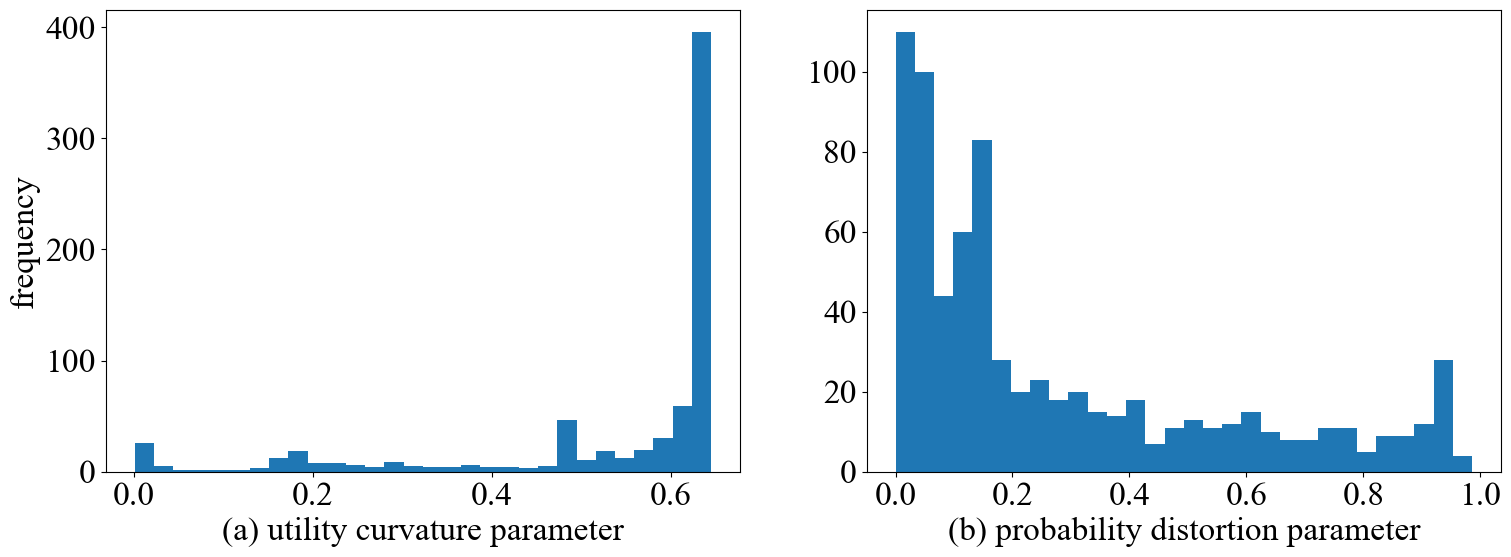

In [8]:
# model = pickle.load(open('models_prob_weigh/pw_class_5.pkl', 'rb'))
# df_equity['class_probW'] = (model.post_prob * model.latent_class['probW']).sum(axis=1)
# df_equity['class_riskCoef'] = (model.post_prob * model.latent_class['riskCoef']).sum(axis=1)

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 24


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.hist(df_equity['riskCoef'],bins=30)
ax1.set_ylabel('frequency')
ax1.set_xlabel('(a) utility curvature parameter')

ax2.hist(df_equity['probW'],bins=30)
ax2.set_xlabel('(b) probability distortion parameter')

plt.show()

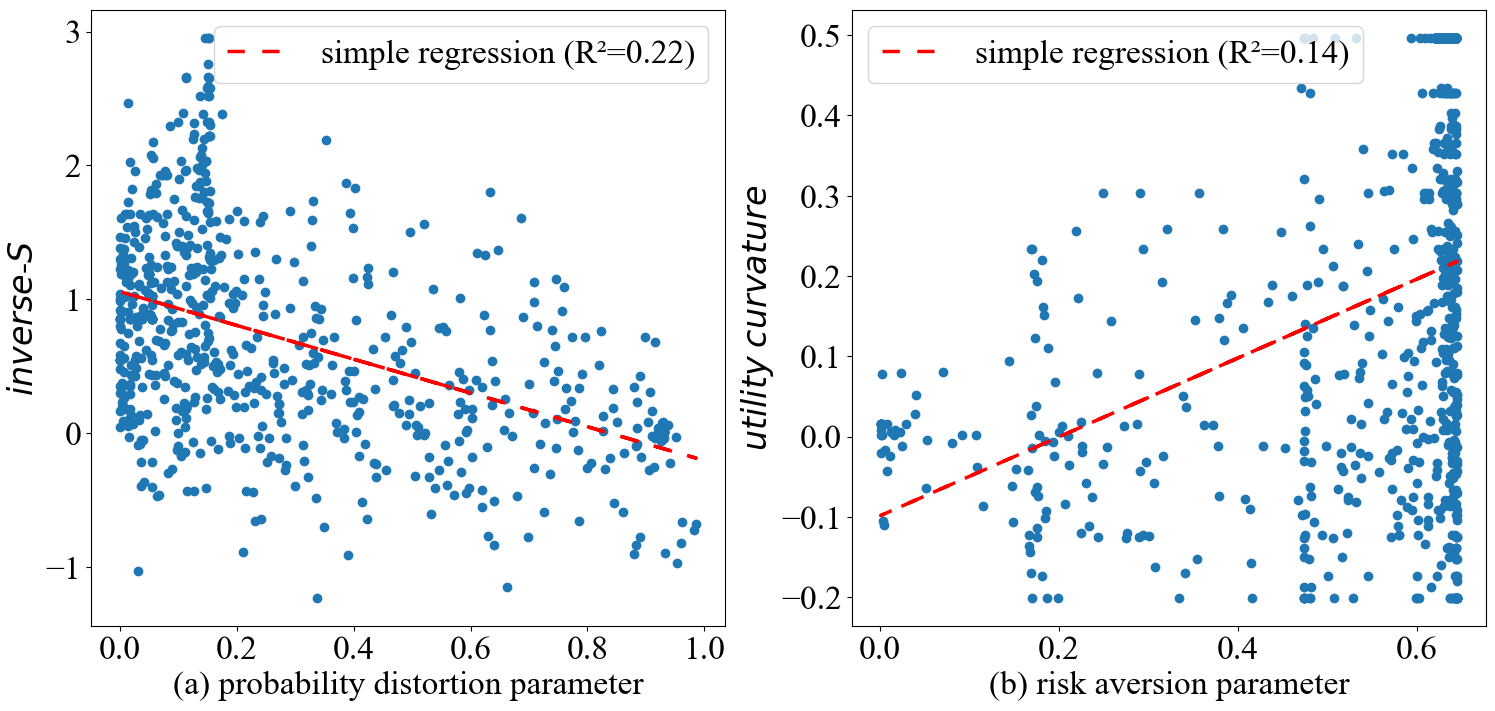

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

ax1.scatter(df_reg_normal['probW'],df_reg_normal['inverse_S'])
ax1.set_xlabel('(a) probability distortion parameter')
ax1.set_ylabel(r"$\mathit{inverse}$-$S$")

slope, intercept, r, p_value, std_err = st.linregress(x=df_reg_normal['probW'], y=df_reg_normal['inverse_S'])
pred_subgroup = slope * df_reg_normal['probW'] + intercept

# reg_simple = sm.WLS(endog=df_reg_normal['inverse_S'],
#                              exog=sm.add_constant(df_reg_normal['probW']),
#                              weights=df_reg_normal['weight']).fit()

# pred_subgroup = reg_simple.params['probW'] * df_reg_normal['probW'] + reg_simple.params['const']
# r = reg_simple.rsquared

ax1.plot(df_reg_normal['probW'], pred_subgroup, color='red', linestyle=(0,(5,5)), linewidth = 2.5, 
         label= f"simple regression (R²={r**2:.2f})")
ax1.legend(loc='best')

ax2.scatter(df_reg_normal['riskCoef'],df_reg_normal['riskaversion'])
ax2.set_xlabel('(b) risk aversion parameter')
ax2.set_ylabel(r'$\mathit{utility\;curvature}$')

slope, intercept, r, p_value, std_err = st.linregress(x=df_reg_normal['riskCoef'], y=df_reg_normal['riskaversion'])
pred_subgroup = slope * df_reg_normal['riskCoef'] + intercept

# reg_simple = sm.WLS(endog=df_reg_normal['riskaversion'],
#                              exog=sm.add_constant(df_reg_normal['riskCoef']),
#                              weights=df_reg_normal['weight']).fit()

# pred_subgroup = reg_simple.params['riskCoef'] * df_reg_normal['riskCoef'] + reg_simple.params['const']
# r = reg_simple.rsquared

ax2.plot(df_reg_normal['riskCoef'], pred_subgroup, color='red', linestyle=(0,(5,5)), linewidth = 2.5, 
         label= f"simple regression (R²={r**2:.2f})")
ax2.legend(loc='best')

plt.show()

In [ ]:
df_consistency_check = df_risk_choice[df_risk_choice['q_risk'].str.split('_').str[1] == '4']
df_consistency_check['q_task'] = df_consistency_check['q_risk'].str.split('_').str[0]
df_consistency_check = df_consistency_check[['prim_key','choice','q_task']].rename(columns = {'choice':'round4_choice'})
df_consistency_check = pd.merge(left = df_consistency_check, right = df_risk_task, on = ['prim_key','q_task'])
df_consistency_check = pd.merge(left = df_consistency_check, right = pd.DataFrame(task_setup), on = 'q_task')

df_consistency_check['pass_check'] = (df_consistency_check['round4_choice'] == df_consistency_check['check'])
df_consistency_check['round4_choice'] = df_consistency_check['round4_choice'].fillna(df_consistency_check['check'])
df_consistency_check['round4_choice'] = 2 - df_consistency_check['round4_choice']

for var in ['prob_a','prob_b','amount_a']:
    df_consistency_check[f'round4_{var}'] = df_consistency_check[var]

df_consistency_check = df_consistency_check.pivot_table(index = 'prim_key',
                    columns = 'q_task',
                    values = [col for col in df_consistency_check.columns if 'round4' in col] + ['pass_check'],
                    aggfunc='first')

df_consistency_check.columns = [f'{task}_{col}' for col, task in df_consistency_check.columns]
df_consistency_check = pd.merge(left = df_equity[['prim_key','weight']],right = df_consistency_check,on='prim_key')

# average pass rate for consistency check
pass_rates = df_consistency_check[[col for col in df_consistency_check.columns if 'pass_check' in col]].mean(axis=1)
average_pass_rate = (pass_rates * df_consistency_check['weight']).sum() / sum(df_consistency_check['weight'])

# predict responses to the consistency check
model = pickle.load(open('models_prob_weigh/pw_class_6.pkl', 'rb'))

p_a_check = [col for col in df_consistency_check.columns if 'prob_a' in col]
p_b_check = [col for col in df_consistency_check.columns if 'prob_b' in col]
x_a_check = [col for col in df_consistency_check.columns if 'amount_a' in col]
x_b_check = [col for col in df_consistency_check.columns if 'x' in col]
choice_check_cols = [col for col in df_consistency_check.columns if 'choice' in col]

check_model = DCM.mixedDiscrete(data=df_consistency_check,
                choice = choice_check_cols,
                x1 = x_a_check,
                x2 = x_b_check,
                p1 = p_a_check,
                p2 = p_b_check,
                fixed_args = model.fixed_args)

check_model.set_init_mixed(latent_class=model.latent_class, 
                           latent_share=model.latent_share,
                           weight=model.sample_weight)

check_model.post_prob = model.post_prob.copy()

check_model.param_keys = ['riskCoef','probW','temp']
check_model.result = pd.DataFrame({'x':const_params})

print('Average pass rate for consistency check:',average_pass_rate)
print('Prediction (latent class):',check_model.predict())
print('Prediction (const model):',check_model.predict(const_model=True))

Average pass rate for consistency check: 0.7856078373234076
Prediction (latent class): {'accuracy': 0.6641423827765867, 'RMSE': 0.2170261311454729, 'cross-entropy': 0.6234937248817484}
Prediction (const model): {'accuracy': 0.6056624476873154, 'RMSE': 0.23419327638111972, 'cross-entropy': 0.6611489154326674}


C:\Users\zarkwang\AppData\Local\Temp\ipykernel_17684\4033231694.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_consistency_check['q_task'] = df_consistency_check['q_risk'].str.split('_').str[0]
